Dataset Shape: (418, 12)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB
None

Missing Values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare       

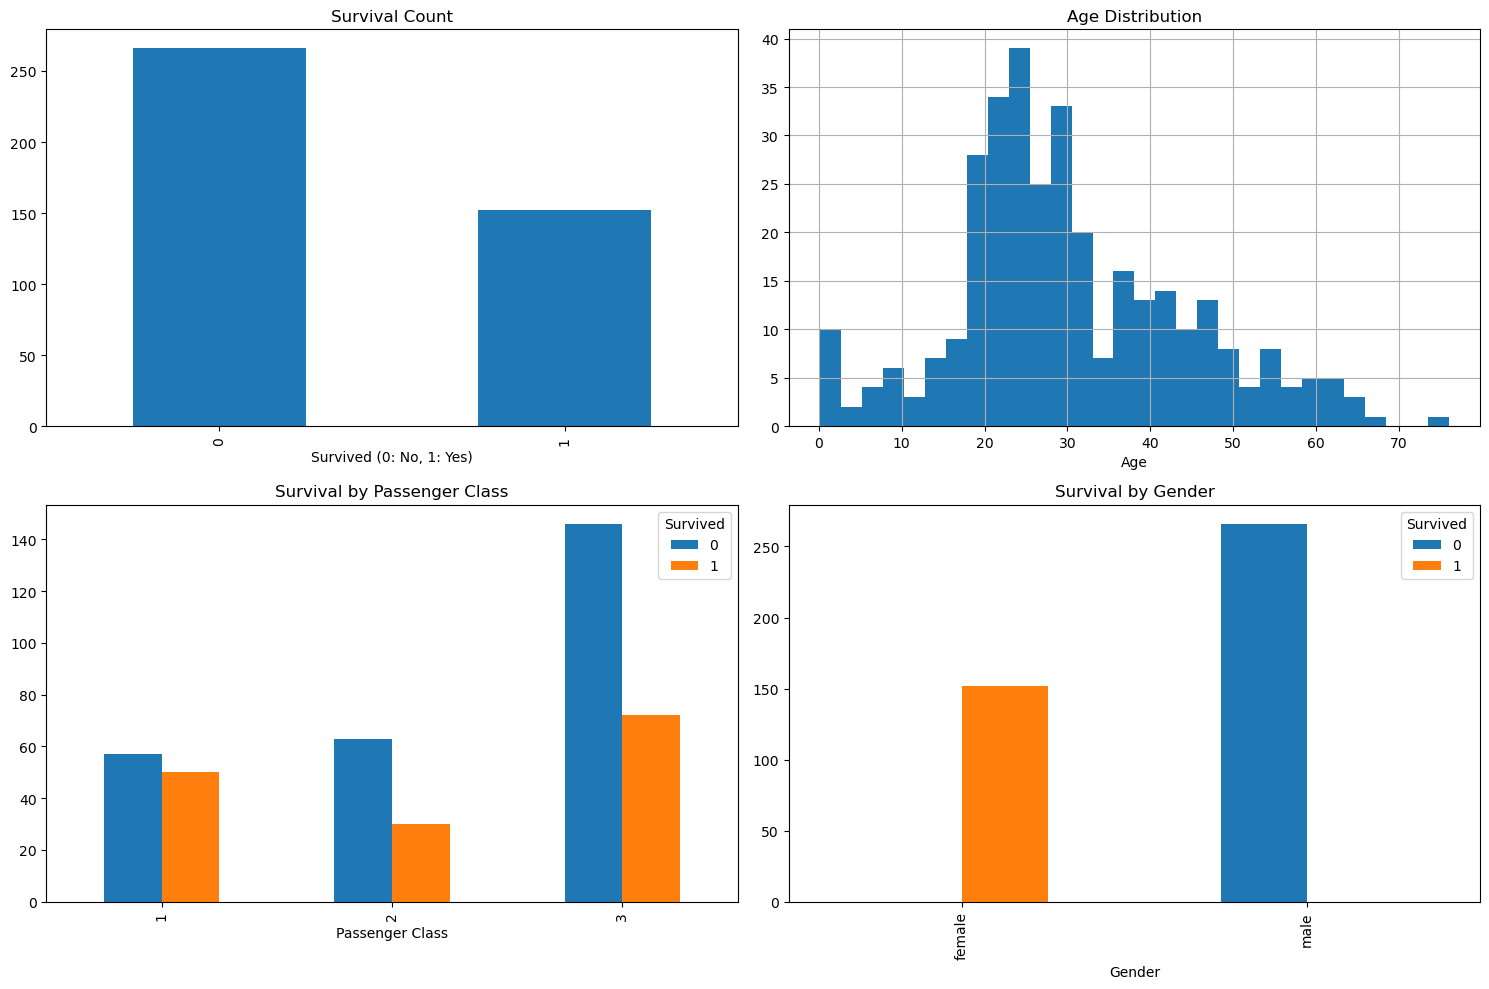

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('titanic.csv')

# Exploratory Data Analysis
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nDataset Description:")
print(df.describe())

# Visualizations for EDA
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Survival rate
df['Survived'].value_counts().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Survival Count')
axes[0,0].set_xlabel('Survived (0: No, 1: Yes)')

# Age distribution
df['Age'].hist(bins=30, ax=axes[0,1])
axes[0,1].set_title('Age Distribution')
axes[0,1].set_xlabel('Age')

# Survival by class
pd.crosstab(df['Pclass'], df['Survived']).plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Survival by Passenger Class')
axes[1,0].set_xlabel('Passenger Class')

# Survival by gender
pd.crosstab(df['Sex'], df['Survived']).plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Survival by Gender')
axes[1,1].set_xlabel('Gender')

plt.tight_layout()
plt.show()

# Data Preprocessing
def preprocess_data(df):
    # Create a copy to avoid modifying original data
    data = df.copy()

    # Handle missing values
    data['Age'].fillna(data['Age'].median(), inplace=True)
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
    data['Fare'].fillna(data['Fare'].median(), inplace=True)

    # Feature Engineering
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

    # Extract title from name
    data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                         'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')

    # Encode categorical variables
    le_sex = LabelEncoder()
    data['Sex_encoded'] = le_sex.fit_transform(data['Sex'])

    le_embarked = LabelEncoder()
    data['Embarked_encoded'] = le_embarked.fit_transform(data['Embarked'])

    le_title = LabelEncoder()
    data['Title_encoded'] = le_title.fit_transform(data['Title'])

    # Select features
    features = ['Pclass', 'Sex_encoded', 'Age', 'SibSp', 'Parch',
                'Fare', 'Embarked_encoded', 'FamilySize', 'IsAlone', 'Title_encoded']

    X = data[features]
    y = data['Survived']

    return X, y, le_sex, le_embarked, le_title

# Preprocess data
X, y, le_sex, le_embarked, le_title = preprocess_data(df)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# Train multiple models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

model_results = {}

for name, model in models.items():
    # Train model
    if name == 'Random Forest':
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X_train_scaled if name != 'Random Forest' else X_train,
                               y_train, cv=5, scoring='accuracy')

    model_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred
    }

    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

# Select best model
best_model_name = max(model_results, key=lambda x: model_results[x]['cv_mean'])
best_model = model_results[best_model_name]['model']

print(f"\nBest Model: {best_model_name}")

# Save the best model and preprocessors
model_data = {
    'model': best_model,
    'scaler': scaler,
    'label_encoders': {
        'sex': le_sex,
        'embarked': le_embarked,
        'title': le_title
    },
    'feature_names': X.columns.tolist(),
    'model_name': best_model_name
}

with open('titanic_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("Model saved successfully!")


Random Forest Results:
Accuracy: 1.0000
CV Score: 1.0000 (+/- 0.0000)
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        31

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84


Logistic Regression Results:
Accuracy: 1.0000
CV Score: 1.0000 (+/- 0.0000)
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        31

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84


SVM Results:
Accuracy: 0.9762
CV Score: 0.9820 (+/- 0.0348)
Classification Report:
              precision    recall  f1-score   support

           0 